# 神奈川県のコロナデータ分析

In [1]:
import datetime as dt
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange
import matplotlib.dates as matdates
from numpy import arange


In [2]:
sns.set_style(style="darkgrid", rc=None)
sns.set(font_scale = 1.2)
plt.figure(figsize=(12, 6))

import japanize_matplotlib

<Figure size 864x432 with 0 Axes>

In [3]:
import sys
sys.path.append('../')
%cd '../'

import src.tool as tool

%reload_ext autoreload
%autoreload 2

/home/tsu-nera/repo/hack-for-corona


In [4]:
patients = tool.read_patients()

In [5]:
patients.tail(5)

,情報公開日,発病確認日,年代,性別,職業,居住地,備考,情報元
68,2020-03-20,2020-03-20,90代,女性,無職,神奈川県横須賀市,NaN,https://www.pref.kanagawa.jp/documents/58277/2...
69,2020-03-20,2020-03-20,30代,男性,会社員,神奈川県横浜市,スペイン在住後帰国,https://www.pref.kanagawa.jp/documents/58277/2...
70,2020-03-21,2020-03-20,60代,男性,会社員,神奈川県平塚保健福祉事務所管内,NaN,https://www.pref.kanagawa.jp/docs/ga4/bukanshi...
71,2020-03-21,2020-03-19,60代,男性,会社員,神奈川県平塚保健福祉事務所管内,NaN,https://www.pref.kanagawa.jp/docs/ga4/bukanshi...
72,2020-03-21,2020-03-19,40代,男性,自営業,神奈川県平塚保健福祉事務所管内,NaN,https://www.pref.kanagawa.jp/docs/ga4/bukanshi...


In [6]:
patients = patients.drop(["備考", "情報元"], axis=1)
patients["id"] = patients.index

## 時間別感染者数

In [7]:
patients["date"] = pd.to_datetime(patients["発病確認日"])

### 日別

In [8]:
patients = patients.sort_values("date")
start_date=patients.iloc[0]["date"]
end_date=patients.iloc[-1]["date"]

In [9]:
date=start_date
dates=[]
while date <= end_date:
    dates.append(date)
    date += dt.timedelta(days=1)
    
dates2=[]
i=0
date=start_date
while date <= end_date:
    if i%7 == 0:
        dates2.append(date.strftime('%Y-%m-%d'))
    else:
        dates2.append(None)
    i+=1
    date += dt.timedelta(days=1)

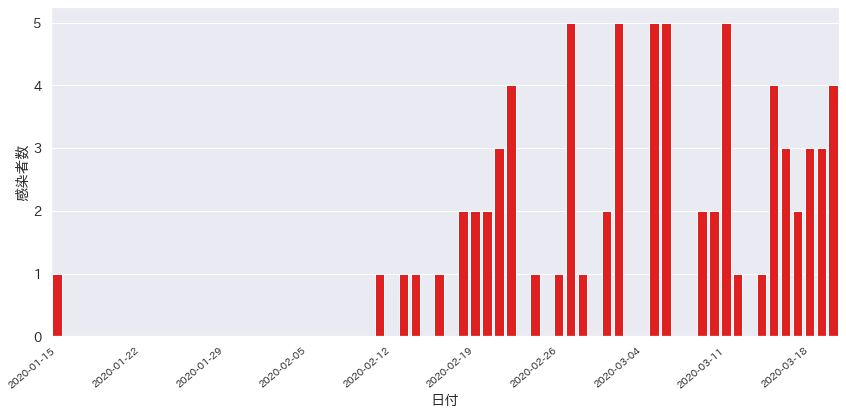

In [10]:
fig,ax = plt.subplots(figsize=(12, 6))

ax = sns.countplot(x="date", data=patients, color="red", order=dates, ax=ax)

ax.set_xticklabels(dates2, rotation=40, ha="right", fontsize=10)
ax.set_xlabel('日付')
ax.set_ylabel('感染者数')

plt.tight_layout()
plt.show()

### 累計

In [21]:
days = patients.groupby("発病確認日").count()

In [29]:
days["date"] = pd.to_datdays.index
days["count"] = days["id"].cumsum()

In [30]:
days

,情報公開日,年代,性別,職業,居住地,id,date,count
発病確認日,,,,,,,,
2020-01-15,1,1,1,0,1,1,2020-01-15,1
2020-02-11,1,0,0,1,1,1,2020-02-11,2
2020-02-13,1,1,1,1,1,1,2020-02-13,3
2020-02-14,1,1,1,1,1,1,2020-02-14,4
2020-02-16,1,1,1,1,1,1,2020-02-16,5
2020-02-18,2,2,2,1,2,2,2020-02-18,7
2020-02-19,2,2,2,2,2,2,2020-02-19,9
2020-02-20,2,1,1,1,2,2,2020-02-20,11
2020-02-21,3,1,1,1,3,3,2020-02-21,14


Text(0, 0.5, '感染者数')

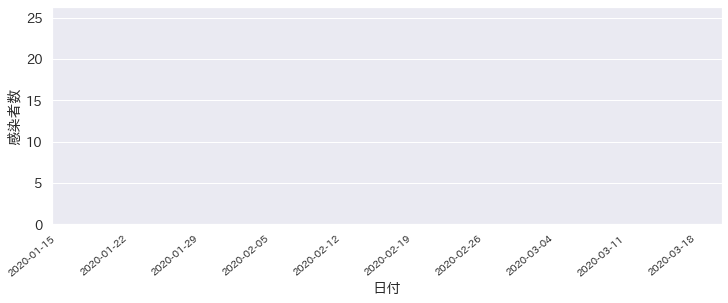

In [32]:
fig,ax = plt.subplots(figsize=(12, 4))

ax = sns.barplot(x="date", y="count", data=days, ax=ax, color="red", order=dates)

ax.set_xticklabels(dates2, rotation=40, ha="right", fontsize=10)
ax.set_xlabel('日付')
ax.set_ylabel('感染者数')

### 週別

In [12]:
##

### 月別

## 属性別感染者数

### 地域別

In [13]:
area = patients
area["居住地"] = patients["居住地"].apply(tool.cut_ku)
area_df = area.groupby("居住地").count().sort_values("id", ascending=False)["id"].to_frame()
area_df.rename(columns={"id": "感染者数"}, inplace=True)

In [14]:
area_df

,感染者数
居住地,
神奈川県相模原市,26
神奈川県横浜市,14
神奈川県平塚保健福祉事務所管内,8
神奈川県鎌倉保健福祉事務所管内,6
神奈川県厚木保健福祉事務所管内,5
神奈川県,4
神奈川県横須賀市,4
神奈川県川崎市,2
神奈川県藤沢市,2


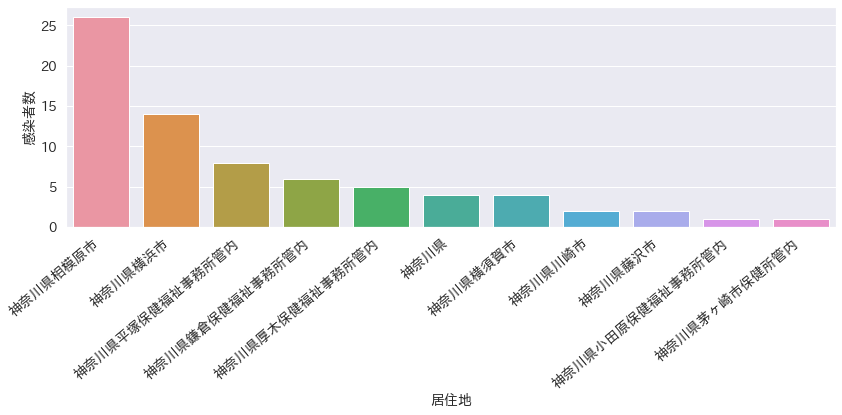

In [15]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(x="居住地", data=area, order=area['居住地'].value_counts().index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=14)
ax.set_xlabel('居住地',fontsize=14)
ax.set_ylabel('感染者数',fontsize=14)

plt.tight_layout()
plt.show()

### 年代別

In [16]:
age = patients
age_df = age.groupby("年代").count()["id"].to_frame()
age_df.rename(columns={"id": "感染者数"}, inplace=True)

In [17]:
age_df

,感染者数
年代,
20代,14
30代,6
40代,7
50代,11
60代,9
70代,13
80代,7
90代,2


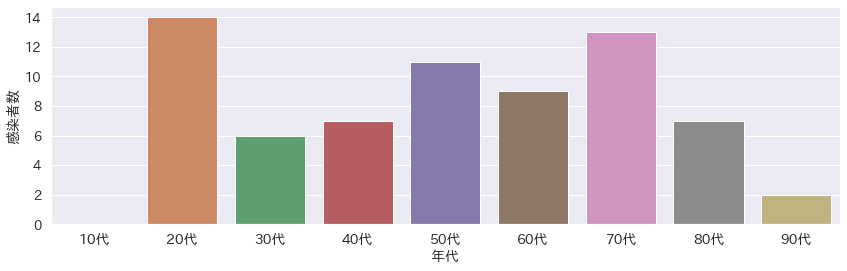

In [18]:
plt.figure(figsize=(12, 4))
ax = sns.countplot(x="年代", data=age, order=["10代", "20代", "30代", "40代", "50代", "60代", "70代", "80代", "90代"])

ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

ax.set_xlabel('年代',fontsize=14)
ax.set_ylabel('感染者数',fontsize=14)

plt.tight_layout()
plt.show()

### 男女別

In [19]:
sex_df = patients
sex_df = sex_df.groupby("性別").count()["id"].to_frame()
sex_df.rename(columns={"id": "感染者数"}, inplace=True)

In [20]:
sex_df

,感染者数
性別,
女性,26
男性,43
